In [1]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from matplotlib.pyplot import specgram
import tensorflow as tf
import math
from random import shuffle
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [17]:
def appendSounds(arrayToAppend,fp):
    X, sr = sf.read(fp)
    sound = np.array(X)
    # librosa operates on (lenght, channels) matrices, wheras soundfile gave us (channels, lenght) 
    # so we transpose
    sound = np.transpose(sound)
    sound = librosa.core.to_mono(sound)
    # resample so every wave has same sampling rate
    sound = librosa.core.resample(sound, sr, 10000)
    # set class number
    classNumber = int(fp.split("/")[1].split("-")[1])
    # compute and set mel spectrogram
    D = np.abs(librosa.stft(sound, hop_length=251,  win_length=1024))**2
    mel = librosa.feature.melspectrogram(S=D, sr=10000, n_mels = 64)
    print mel.shape
    iterator, sliceSize = 0,10
    while iterator+10<=mel.shape[1]:
        arrayToAppend.append(Sound(classNumber,mel[:,iterator:iterator+10]))
        iterator+=10

In [3]:
class Sound:
    def __init__(self, classNumber, mel):
        self.classNumber=classNumber
        self.mel = mel
        

In [18]:
ayy = []
appendSounds(ayy, "fold1/14113-4-0-1.wav")
for x in ayy:
    print x.classNumber, x.mel.shape

(64, 160)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)
4 (64, 10)


In [6]:
class NeuralNetwork:
    countNetwoks=0
    def __init__(self,numin=None,numout=None,hiddenlayers=None,learningrate=None,arrtrain=None,arrtest=None,neural=None):
        NeuralNetwork.countNetwoks+=1
        self.myId=NeuralNetwork.countNetwoks
        if neural!=None:
            self.numIn=neural.numIn
            self.numOut=neural.numOut
            self.hiddenLayers=neural.hiddenLayers[:]
            self.learningRate=neural.learningRate
            if numin!=None:
                self.numIn = numin
            if numout!= None:
                self.numOut= numout
            if hiddenlayers!= None:
                self.hiddenLayers=hiddenlayers[:]
            if learningrate!= None:
                self.learningRate=learningrate
        else:
            self.numIn=numin
            self.numOut=numout
            self.hiddenLayers = hiddenlayers
            self.learningRate = learningrate
    def train(self,arrtrain,arrtest=None):
        prepareNet(self.numIn,self.numOut,self.hiddenLayers,self.learningRate,arrtrain,self.myId)
        if arrtest!= None:
            self.scores = testNet(arrtest, self.myId)
            self.mainScore = self.scores.trace()/self.scores.sum()
    def test(self,arrtest):
            self.scores = testNet(arrtest, self.myId)
            self.mainScore = self.scores.trace()/self.scores.sum()        
            
        

In [7]:
from multiprocessing import Process, Lock, Pipe,Event
import time



arrtrain = []
arrtuning=[]
arrtest=[]
def add(x,c):
    temp = []
    for file in glob.glob(x):
        appendSounds(temp,file)
    c.send(temp)
    del temp
        
ts = time.time()

if __name__ == '__main__':
    threads= []
    connections=[0]*10
    lock = Lock()
    for x in xrange(1,11):
        connections[x-1],childPipe=Pipe()
        threads.append(Process(target=add, args=("fold"+str(x)+"/*.wav",childPipe)))         
        threads[x-1].start()
    fold = 1
    for x,y in zip(threads,connections):
        if fold < 9:
           arrtrain.extend(y.recv())
        elif fold == 8 :
           arrtuning.extend(y.recv())
        else:
           arrtest.extend(y.recv())
        fold+=1
    print "I'm done, time was:" , time.time()-ts

I'm done, time was: 1747.25513101


In [12]:


# 2.4 Build inference graph.
def mnist_inference(sounds, numin,numout,hiddenLayers):
    """Build the MNIST model up to where it may be used for inference.
    Args:
        images: Images placeholder.
        hidden1_units: Size of the first hidden layer.
        hidden2_units: Size of the second hidden layer.
    Returns:
        logits: Output tensor with the computed logits.
    """
    hidden=[]
    # Hidden 1
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal([numin, hiddenLayers[0]],
                                stddev=1.0 / math.sqrt(float(numin))),
            name='weights')
        biases = tf.Variable(tf.zeros([hiddenLayers[0]]),
                             name='biases')
        hidden.append(tf.nn.relu(tf.matmul(sounds, weights) + biases))
    
    for i in xrange(1,len(hiddenLayers)):
        with tf.name_scope('hidden'+str(i+1)):
            weights = tf.Variable(
                tf.truncated_normal([hiddenLayers[i-1], hiddenLayers[i]],
                                    stddev=1.0 / math.sqrt(float(hiddenLayers[i-1]))),
                name='weights')
            biases = tf.Variable(tf.zeros([hiddenLayers[i]]),
                                 name='biases')
            hidden.append(tf.nn.relu(tf.matmul(hidden[i-1], weights) + biases))
        
    # Linear
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal([hiddenLayers[-1], numout],
                                stddev=1.0 / math.sqrt(float(hiddenLayers[-1]))),
            name='weights')
        biases = tf.Variable(tf.zeros([numout]),
                             name='biases')
        logits = tf.matmul(hidden[-1], weights) + biases

    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "inference.pbtxt", as_text=True)
    return logits

# 2.5 Build training graph.
def mnist_training(logits, labels, learning_rate):
    """Build the training graph.

    Args:
        logits: Logits tensor, float - [BATCH_SIZE, NUM_CLASSES].
        labels: Labels tensor, int32 - [BATCH_SIZE], with values in the
          range [0, NUM_CLASSES).
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
        loss: The Op for calculating loss.
    """
    # Create an operation that calculates loss.
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits, labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # Create a variable to track the global step.
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "train.pbtxt", as_text=True)

    return train_op, loss

# 2.6 Build the complete graph for feeding inputs, training, and saving checkpoints.
def prepareNet(numin,numout,hiddenLayers, learningRate,trainset,saveId):
    mnist_graph = tf.Graph()
    with mnist_graph.as_default():
        # Generate placeholders for the images and labels.
        images_placeholder = tf.placeholder(tf.float32)                                       
        labels_placeholder = tf.placeholder(tf.int32)
        tf.add_to_collection("images", images_placeholder)  # Remember this Op.
        tf.add_to_collection("labels", labels_placeholder)  # Remember this Op.

        # Build a Graph that computes predictions from the inference model.
        logits = mnist_inference(images_placeholder,numin,numout,hiddenLayers)
        tf.add_to_collection("logits", logits)  # Remember this Op.

        # Add to the Graph the Ops that calculate and apply gradients.
        train_op, loss = mnist_training(logits, labels_placeholder, learningRate)

        # Add the variable initializer Op.
        init = tf.global_variables_initializer()

        # Create a saver for writing training checkpoints.
        saver = tf.train.Saver()

        # Uncomment the following line to see what we have constructed.
        # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
        #                      "/tmp", "complete.pbtxt", as_text=True)
    
    # 2.7 Run training for MAX_STEPS and save checkpoint at the end.
    with tf.Session(graph=mnist_graph) as sess:
        # Run the Op to initialize the variables.
        sess.run(init)
        losses = []
        counter=0
        # Start the training loop.
        for i in xrange (10):
            shuffle(trainset)
            iterator = 0
            # Read a batch of images and labels.
            #images_feed, labels_feed = data_sets.train.next_batch(BATCH_SIZE)
            print "Step:", i+1
            while iterator<=len(trainset):
                mel_feed, labels_feed = [],[]
                for x in trainset[iterator:iterator+16]:
                    mel_feed.append(x.mel.flatten())
                    labels_feed.append(x.classNumber)
                #print np.array(mel_feed).shape, " ", np.array(labels_feed).shape


                # Run one step of the model.  The return values are the activations
                # from the `train_op` (which is discarded) and the `loss` Op.  To
                # inspect the values of your Ops or variables, you may include them
                # in the list passed to sess.run() and the value tensors will be
                # returned in the tuple from the call.
                if not (len(labels_feed)==0):
                    _, loss_value = sess.run([train_op, loss],
                                             feed_dict={images_placeholder: np.array(mel_feed),
                                                        labels_placeholder: np.array(labels_feed)})
                    losses.append(loss_value)
                # Print out loss value.
                counter +=1
                #if counter % 1000 == 0:
                    #print('Step %d: loss = %.2f' % (counter, loss_value))
                iterator+=16



        # Write a checkpoint.
        #checkpoint_file = os.path.join(TRAIN_DIR, 'checkpoint')
        #saver.save(sess, checkpoint_file, global_step=step)
        checkpoint_file = os.path.join("/tmp/sound", 'checkpoint')
        saver.save(sess, checkpoint_file,global_step=saveId)
        plt.plot(losses)

def testNet(testingset,saveId):

    with tf.Session(graph=tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            os.path.join("/tmp/sound", "checkpoint-"+str(saveId)+".meta"))
        saver.restore(
            sess, os.path.join("/tmp/sound", "checkpoint-"+str(saveId)))


        # Retrieve the Ops we 'remembered'.
        logits = tf.get_collection("logits")[0]
        images_placeholder = tf.get_collection("images")[0]
        labels_placeholder = tf.get_collection("labels")[0]
        # Add an Op that chooses the top k predictions.

        eval_op = tf.nn.top_k(logits)

        scores = np.zeros((10,10))
        for x in testingset:
            mel_feed=[x.mel.flatten()]
            labels_feed=[x.classNumber]
            mel_feed, labels_feed = np.array(mel_feed), np.array(labels_feed)

                # Run evaluation.
                #images_feed, labels_feed = data_sets.validation.next_batch(EVAL_BATCH_SIZE)
            prediction = sess.run(eval_op,
                                      feed_dict={images_placeholder: mel_feed,
                                                 labels_placeholder: labels_feed})
                #print type(labels_feed[0]), type(prediction.indices[0][0])
            temp=(prediction.indices[0][0])
                #if labels_feed[0] == prediction.indices[0][0]:
                #   good+=1
                #total +=1
            
            scores[labels_feed[0],temp]+=1
            #if good*2 >= total:
             #   print labels_feed, " : ", good, "/", total
            #print count
        return scores
        #counter = 0
        #for x in scores:
        #    print "Class %d: %.2f  Quantity: %d" %(counter, x[counter]/np.sum(x), np.sum(x))
        #    counter +=1
        #print "Final score: ", scores.trace()/scores.sum()

In [9]:
def findLearningRate(neural,learnValues,arrtrain,arrtune):
    neuralNets=[]
    for x in learnValues:
        neuralNets.append(NeuralNetwork(learningrate=x, neural=neural))
    for x in neuralNets:
        x.train(arrtrain,arrtune)
        print "Learning rate:", x.learningRate, "score:", x.mainScore
    bestNet,bestScore=0,0
    for i in xrange (len(neuralNets)):
        if bestScore<neuralNets[i].mainScore:
            bestScore=neuralNets[i].mainScore
            bestNet=i
    return neuralNets[bestNet]

In [ ]:
d= NeuralNetwork(640,10,[500,600,170])
bestNet=findLearningRate(d,[0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.001],arrtrain,arrtuning)
bestNet.test(arrtest)
print bestNet.scores
print bestNet.mainScore


In [ ]:
bestNet.test(arrtrain)
print bestNet.scores
print bestNet.mainScore

Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
0.278160147725
0.303775902373


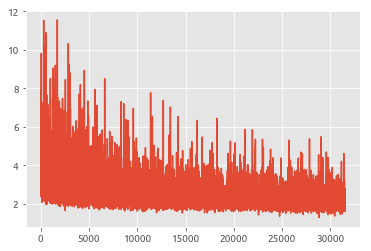

In [19]:
e = NeuralNetwork(640,10,[300,120,30],0.00001)
e.train(arrtrain,arrtest)
#print e.scores
print e.mainScore
e.test(arrtrain)
print e.mainScore

0.385009232835


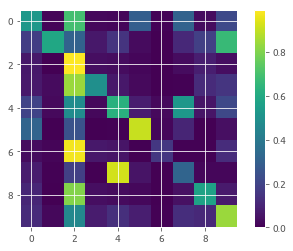

In [18]:
e.test(arrtest)
print e.mainScore
from sklearn.preprocessing import normalize
normscores =normalize(e.scores)
plt.imshow(normscores)
plt.colorbar()

// OLD VERSION BELOW //


In [ ]:


# 2.4 Build inference graph.
def mnist_inference(sounds, hidden1_units, hidden2_units, hidden3_units):
    """Build the MNIST model up to where it may be used for inference.
    Args:
        images: Images placeholder.
        hidden1_units: Size of the first hidden layer.
        hidden2_units: Size of the second hidden layer.
    Returns:
        logits: Output tensor with the computed logits.
    """
    # Hidden 1
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal([1280, hidden1_units],
                                stddev=1.0 / math.sqrt(float(1280))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden1_units]),
                             name='biases')
        hidden1 = tf.nn.relu(tf.matmul(sounds, weights) + biases)
    # Hidden 2
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal([hidden1_units, hidden2_units],
                                stddev=1.0 / math.sqrt(float(hidden1_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden2_units]),
                             name='biases')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
        
    # Hidden 3
    with tf.name_scope('hidden3'):
        weights = tf.Variable(
            tf.truncated_normal([hidden2_units, hidden3_units],
                                stddev=1.0 / math.sqrt(float(hidden2_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([hidden3_units]),
                             name='biases')
        hidden3 = tf.nn.relu(tf.matmul(hidden2, weights) + biases)
    # Linear
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal([hidden3_units, 10],
                                stddev=1.0 / math.sqrt(float(hidden3_units))),
            name='weights')
        biases = tf.Variable(tf.zeros([10]),
                             name='biases')
        logits = tf.matmul(hidden3, weights) + biases

    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "inference.pbtxt", as_text=True)
    return logits

In [ ]:
# 2.5 Build training graph.
def mnist_training(logits, labels, learning_rate):
    """Build the training graph.

    Args:
        logits: Logits tensor, float - [BATCH_SIZE, NUM_CLASSES].
        labels: Labels tensor, int32 - [BATCH_SIZE], with values in the
          range [0, NUM_CLASSES).
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
        loss: The Op for calculating loss.
    """
    # Create an operation that calculates loss.
    labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits, labels, name='xentropy')
    loss = tf.reduce_mean(cross_entropy, name='xentropy_mean')
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # Create a variable to track the global step.
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # Use the optimizer to apply the gradients that minimize the loss
    # (and also increment the global step counter) as a single training step.
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "train.pbtxt", as_text=True)

    return train_op, loss

In [ ]:
# 2.6 Build the complete graph for feeding inputs, training, and saving checkpoints.
mnist_graph = tf.Graph()
with mnist_graph.as_default():
    # Generate placeholders for the images and labels.
    images_placeholder = tf.placeholder(tf.float32)                                       
    labels_placeholder = tf.placeholder(tf.int32)
    tf.add_to_collection("images", images_placeholder)  # Remember this Op.
    tf.add_to_collection("labels", labels_placeholder)  # Remember this Op.

    # Build a Graph that computes predictions from the inference model.
    logits = mnist_inference(images_placeholder,
                             1000,
                             600, 
                             170)
    tf.add_to_collection("logits", logits)  # Remember this Op.

    # Add to the Graph the Ops that calculate and apply gradients.
    train_op, loss = mnist_training(logits, labels_placeholder, 0.0001)

    # Add the variable initializer Op.
    init = tf.initialize_all_variables()

    # Create a saver for writing training checkpoints.
    saver = tf.train.Saver()
    
    # Uncomment the following line to see what we have constructed.
    # tf.train.write_graph(tf.get_default_graph().as_graph_def(),
    #                      "/tmp", "complete.pbtxt", as_text=True)

In [ ]:
# 2.7 Run training for MAX_STEPS and save checkpoint at the end.
with tf.Session(graph=mnist_graph) as sess:
    # Run the Op to initialize the variables.
    sess.run(init)
    losses = []
    counter=0
    # Start the training loop.
    for x in arrtest:
        # Read a batch of images and labels.
        #images_feed, labels_feed = data_sets.train.next_batch(BATCH_SIZE)
        mel_feed, labels_feed = [],[]
        for z in xrange(x.mel.shape[1]/10):
            mel_feed.append(x.mel[:,z*10:(z+1)*10].flatten())
            labels_feed.append(x.classNumber)
        #print np.array(mel_feed).shape, " ", np.array(labels_feed).shape
        
        
        # Run one step of the model.  The return values are the activations
        # from the `train_op` (which is discarded) and the `loss` Op.  To
        # inspect the values of your Ops or variables, you may include them
        # in the list passed to sess.run() and the value tensors will be
        # returned in the tuple from the call.
        if not (len(labels_feed)==0):
            _, loss_value = sess.run([train_op, loss],
                                     feed_dict={images_placeholder: np.array(mel_feed),
                                                labels_placeholder: np.array(labels_feed)})
            losses.append(loss_value)
        # Print out loss value.
        counter +=1
        if counter % 1000 == 0:
            print('Step %d: loss = %.2f' % (counter, loss_value))
                      
    
            
    # Write a checkpoint.
    #checkpoint_file = os.path.join(TRAIN_DIR, 'checkpoint')
    #saver.save(sess, checkpoint_file, global_step=step)
    checkpoint_file = os.path.join("/tmp/sound", 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=counter)
    plt.plot(losses)

In [ ]:
evaluation = []
for file in glob.glob("fold9/*.wav"):
    evaluation.append(Sound(file))
for file in glob.glob("fold10/*.wav"):
    evaluation.append(Sound(file))

In [ ]:
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join("/tmp/sound", "checkpoint-7079.meta"))
    saver.restore(
        sess, os.path.join("/tmp/sound", "checkpoint-7079"))


    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    images_placeholder = tf.get_collection("images")[0]
    labels_placeholder = tf.get_collection("labels")[0]
    # Add an Op that chooses the top k predictions.
        
    eval_op = tf.nn.top_k(logits)
    
    scores = np.zeros((10,10))
    for x in evaluation:
        good, total = 0, 0
        temp = []
        for z in xrange(x.mel.shape[1]/10):
            mel_feed, labels_feed = [],[]
            mel_feed.append(x.mel[:,z*10:(z+1)*10].flatten())
            labels_feed.append(x.classNumber)
            mel_feed, labels_feed = np.array(mel_feed), np.array(labels_feed)

            # Run evaluation.
            #images_feed, labels_feed = data_sets.validation.next_batch(EVAL_BATCH_SIZE)
            prediction = sess.run(eval_op,
                                  feed_dict={images_placeholder: mel_feed,
                                             labels_placeholder: labels_feed})
            #print type(labels_feed[0]), type(prediction.indices[0][0])
            temp.append(prediction.indices[0][0])
            #if labels_feed[0] == prediction.indices[0][0]:
            #   good+=1
            #total +=1
        if temp:
            scores[labels_feed[0],max(set(temp), key=temp.count)]+=1
        #if good*2 >= total:
         #   print labels_feed, " : ", good, "/", total
        #print count
    print scores
    counter = 0
    for x in scores:
        print "Class %d: %.2f  Quantity: %d" %(counter, x[counter]/np.sum(x), np.sum(x))
        counter +=1
    print "Final score: ", scores.trace()/scores.sum()

In [ ]:
from sklearn.preprocessing import normalize
normscores =normalize(scores)
plt.imshow(normscores)
plt.colorbar()